<a href="https://colab.research.google.com/github/yiruchen4/Chen2025/blob/main/Code/ChenFigure1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pingouin > /dev/null 2>&1
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import Image
import warnings
import pingouin as pg

warnings.filterwarnings("ignore")

def add_sig_line(ax, x1, x2, y, p_val, h=1):
    if p_val < 0.0001:
        stars = '****'
    elif p_val < 0.001:
        stars = '***'
    elif p_val < 0.01:
        stars = '**'
    elif p_val < 0.05:
        stars = '*'
    else:
        return
    ax.text((x1 + x2) / 2, y, stars, ha='center', va='bottom', fontsize=13, fontweight='bold')

In [3]:
# @title Figure 1A
Image(url='https://github.com/yiruchen4/Chen2025/blob/main/Images/Figure%201A.png?raw=true', width=600)

In [4]:
# @title Figure 1B
Image(url='https://github.com/yiruchen4/Chen2025/blob/main/Images/Figure%201B.png?raw=true', width=600)

In [5]:
# @title Figure 1C
Image(url='https://github.com/yiruchen4/Chen2025/blob/main/Images/Figure%201C.png?raw=true', width=600)

In [7]:
# @title Figure 1D
Image(url='https://github.com/yiruchen4/Chen2025/blob/main/Images/Figure%201D.png?raw=true', width=400)

                A                B            T  dof       p-unc      p-corr  \
0    Active_Empty    Active_Social  -9.48459908  8.0  0.00001258  0.00007550   
1    Active_Empty   Inactive_Empty   3.22711899  8.0  0.01210919  0.07265512   
2    Active_Empty  Inactive_Social   4.93986006  8.0  0.00113526  0.00681158   
3   Active_Social   Inactive_Empty   8.82557690  8.0  0.00002139  0.00012836   
4   Active_Social  Inactive_Social  12.59076991  8.0  0.00000149  0.00000891   
5  Inactive_Empty  Inactive_Social   1.09842801  8.0  0.30397334  1.00000000   

        cohen  
0 -3.71445988  
1  1.35723335  
2  2.28516469  
3  4.78297476  
4  5.85208127  
5  0.49221907  


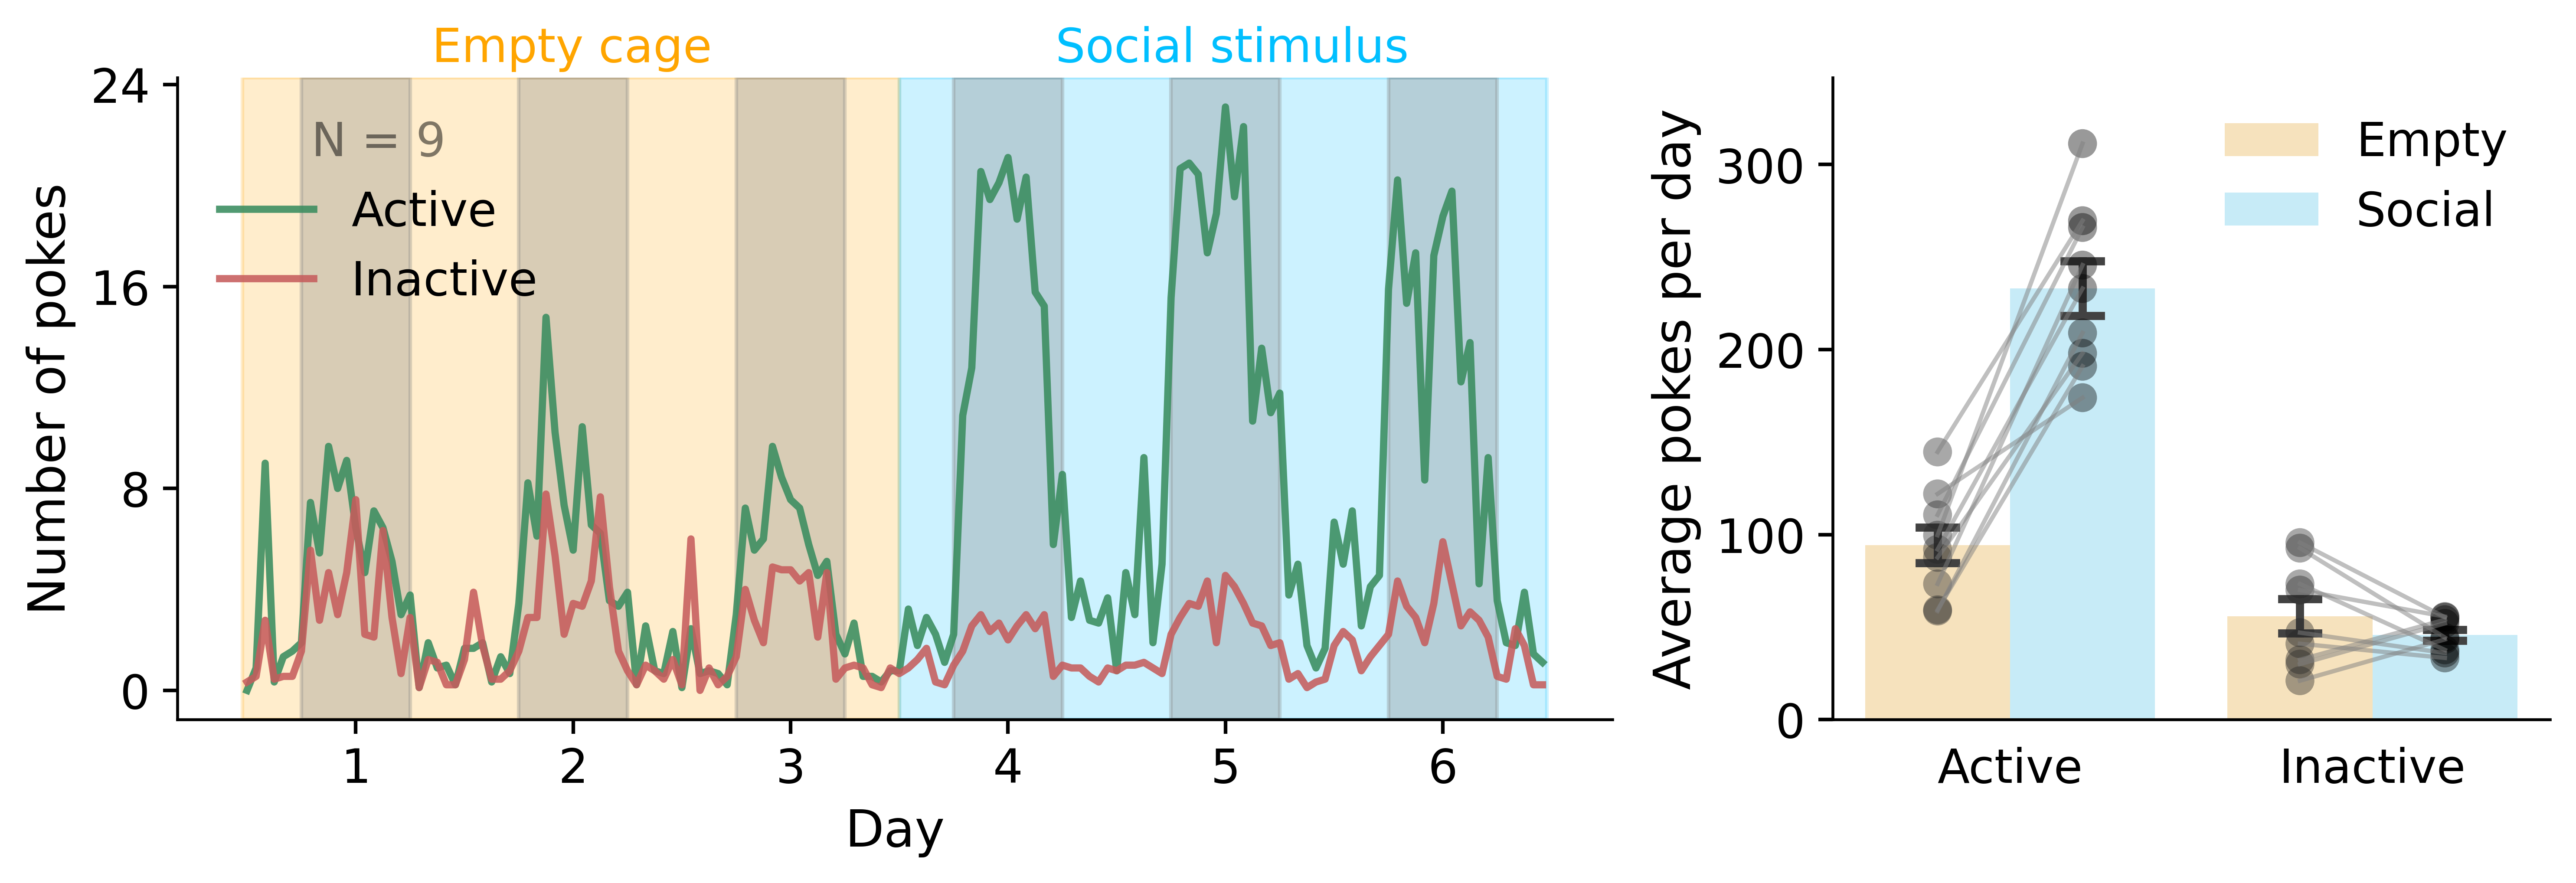

In [9]:
# @title Figure 1E-F
# Load and preprocess data
poke_counts = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_Figure1.csv")

# === Combined Figure ===
fig = plt.figure(figsize=(10, 3.5), dpi=600)
gs = fig.add_gridspec(1, 2, width_ratios=[3, 1.5])

# === LEFT PLOT: Clustered Door Opening ===
ax1 = fig.add_subplot(gs[0, 0])
xtick_positions = range(-60, 3 * 24 - 11, 24)
xtick_labels = [1, 2, 3, 4, 5, 6]

ax1.axvspan(-72.5, 0, color='orange', alpha=0.2)
ax1.axvspan(0, 3 * 24-0.5, color='deepskyblue', alpha=0.2)

sns.lineplot(
    data=poke_counts,
    x="hoursfloor",
    y="count",
    hue="poke_reward",
    errorbar=None,
    lw = 2,
    ax=ax1,
    palette={
        "Active": "#3A8D5FE1",       # Active poke
        "Inactive": "#C65C5CDF",      # Light red for inactive
    }
)

for start in range(-66, 3 * 24 + 1, 24):
    ax1.axvspan(start, start + 12, color="grey", alpha=0.3)

ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, fontsize=13)
ax1.tick_params(axis="y", labelsize=13)
ax1.set_xlabel("Day", fontsize=14)
ax1.set_ylabel("Number of pokes", fontsize=14)
ax1.yaxis.set_major_locator(MaxNLocator(4, integer=True))
ax1.text(0.275, 1.025, "Empty cage", fontsize=13, color='orange', ha='center', transform=ax1.transAxes)
ax1.text(0.735, 1.025, "Social stimulus", fontsize=13, color='deepskyblue', ha='center', transform=ax1.transAxes)
legend1 = ax1.legend(title=f'N = {len(poke_counts["device_number"].unique())}', title_fontsize=13, loc="upper left", frameon=False, fontsize=13)
legend1.get_title().set_alpha(0.5)
sns.despine(ax=ax1)

# === RIGHT PLOT: Paired Bar Chart ===
ax2 = fig.add_subplot(gs[0, 1])
bar_colors = ['#FFE5B4', '#BFEFFF']
day_poke_counts = poke_counts.groupby(["device_number", 'mode', 'sex', "days", "poke_reward"])['count'].sum().reset_index()
avg_poke_counts = day_poke_counts.groupby(["device_number", 'mode', 'sex', "poke_reward"])['count'].mean().reset_index()

sns.barplot(data=avg_poke_counts, x='poke_reward', y='count', hue='mode', errorbar="se", capsize=.2, palette=bar_colors, ax=ax2)
sns.stripplot(data=avg_poke_counts, x='poke_reward', y='count', hue='mode', color='black', dodge=True, jitter=False, alpha=0.4, size=8, ax=ax2, legend=False)

x_positions = {"Active": 0, "Inactive": 1}
for interaction in avg_poke_counts['poke_reward'].unique():
    subset = avg_poke_counts[avg_poke_counts['poke_reward'] == interaction]
    empty = subset[subset["mode"] == "Empty"].reset_index(drop=True)
    social = subset[subset["mode"] == "Social"].reset_index(drop=True)
    for i in range(len(empty)):
        ax2.plot(
            [x_positions[interaction] - 0.2, x_positions[interaction] + 0.2],
            [empty.loc[i, "count"], social.loc[i, "count"]],
            color="gray", alpha=0.5, linewidth=1.2, zorder=4
        )

ax2.set_ylim([0, ax2.get_ylim()[1]+20])
ax2.set_xlabel("")
ax2.set_ylabel("Average pokes per day", fontsize=14)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(["Active", "Inactive"], fontsize=14)
ax2.tick_params(axis="y", labelsize=13)
ax2.yaxis.set_major_locator(MaxNLocator(4, integer=True))
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:2], labels[:2], fontsize=13, frameon=False)
sns.despine(ax=ax2, left=False)
# # ax2.text(0.5, 0.95, 'p < 0.0001', ha='center', va='bottom', fontsize=14, transform=ax2.transAxes)
ax1.tick_params(
    axis='both',          # apply to x and y
    which='major',
    bottom=True, top=False, left=True, right=False,
    length=4, width=1,    # make tick marks visible
    direction='out',      # tick marks outside
    labelsize=13
)

ax2.tick_params(
    axis='both',
    which='major',
    left=True, top=False, right=False, bottom=False,
    length=4, width=1,
    direction='out',
    labelsize=13
)

# # Save output
plt.tight_layout()

# Step 1: Make a new column combining poke_reward and mode
avg_poke_counts["condition"] = avg_poke_counts["poke_reward"] + "_" + avg_poke_counts["mode"]

# Step 2: Restructure data for post-hoc
df_posthoc = avg_poke_counts[["device_number", "count", "condition"]].copy()

# Step 3: Run pairwise post-hoc test with Bonferroni correction
pairwise = pg.pairwise_tests(
    data=df_posthoc,
    dv="count",
    within="condition",
    subject="device_number",
    padjust="bonf",   # Bonferroni correction
    effsize="cohen"   # Get Cohen's d
)

# Step 4: Show key results with high precision
pd.set_option("display.precision", 8)
print(pairwise[["A", "B", "T", "dof", "p-unc", "p-corr", "cohen"]])